<a href="https://colab.research.google.com/github/KLAW4life/Machine-Learning-Algorithms/blob/main/MachineLearningAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Work 1


In [ ]:
# Importing the necessary libraries needed
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve)
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

Task 1: [25 points] Explore the Data
Load the provided dataset and see how many data points and features it has. Count how many
samples belong to each type of cancer and make a simple bar chart.

Number of data points (rows): 2529
Number of features (columns): 12311
Class
KIRC    527
LUAD    510
THCA    501
LUSC    498
PRAD    493
Name: count, dtype: int64


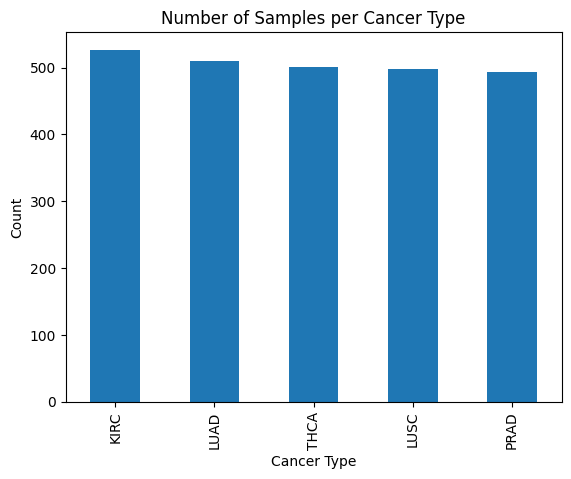

In [ ]:
# Loading the dataset from the csv file and counting the number of datapoints and features
df = pd.read_csv('lncRNA_5_Cancers.csv')
# print(df.shape)

# Check shape (rows = data points, columns = features)
print("Number of data points (rows):", df.shape[0])
print("Number of features (columns):", df.shape[1])

# Looking at the dataset for the columns
# df.head()

# Counting the types of cancer in the dataset
cancer_counts = df['Class'].value_counts()
print(cancer_counts)

# Plot Bar graph
# Plot bar chart
cancer_counts.plot(kind='bar')
plt.title("Number of Samples per Cancer Type")
plt.xlabel("Cancer Type")
plt.ylabel("Count")
plt.show()


Task 2: [25 points] Classification Using All Features Employing SVM
Use those ~12K features to train an SVM with RBF kernel. Report (i) confusion matrix for one
fold, (ii) the macro, micro, and weighted precision/recall/F1 along with the accuracy, (iii) plot
AUC-ROC and AUC-PR curve. Use 5-flod cross-validation.

Confusion Matrix (first fold):
 [[102   1   3   0   0]
 [  0 101   1   0   0]
 [  0   6  93   0   0]
 [  0   3   0  96   0]
 [  0   1   0   0  99]]

Classification Report (macro/micro/weighted):
              precision    recall  f1-score   support

        KIRC       1.00      0.98      0.99       527
        LUAD       0.85      0.97      0.91       510
        LUSC       0.95      0.89      0.92       498
        PRAD       1.00      0.96      0.98       493
        THCA       1.00      0.98      0.99       501

    accuracy                           0.96      2529
   macro avg       0.96      0.96      0.96      2529
weighted avg       0.96      0.96      0.96      2529



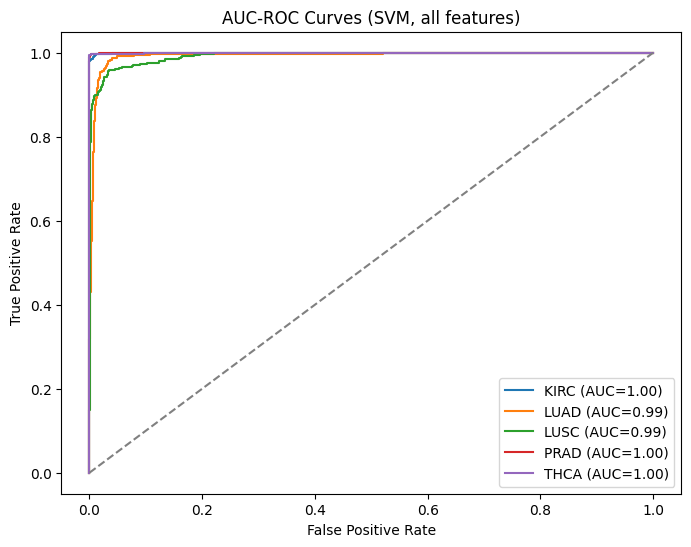

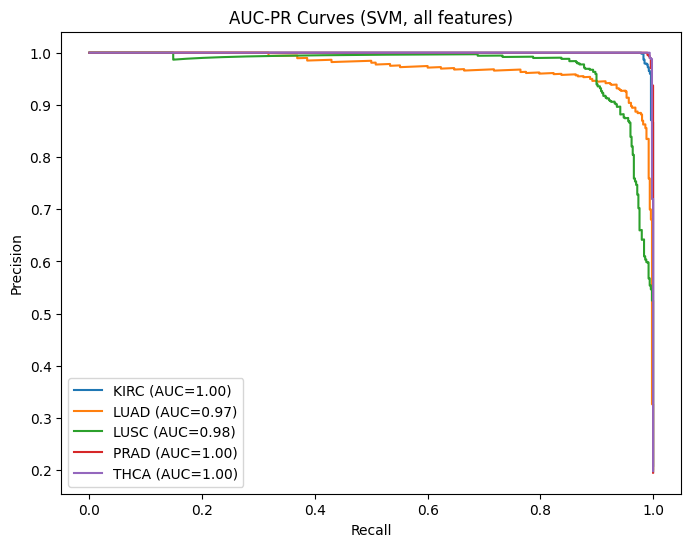

In [ ]:
# import numpy as np
# from sklearn.model_selection import StratifiedKFold, cross_val_predict
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.svm import SVC
# from sklearn.metrics import (confusion_matrix, classification_report,
#                              roc_curve, auc, precision_recall_curve)
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import label_binarize

# Prepare features/labels
X = df.drop(columns=["Ensembl_ID", "Class"])
y = df["Class"]

le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_

# Pipeline: scaling + SVM with RBF kernel
svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", probability=True, random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 1) Confusion matrix for first fold ---
train_idx, test_idx = next(cv.split(X, y_enc))
svm.fit(X.iloc[train_idx], y_enc[train_idx])
y_pred_fold = svm.predict(X.iloc[test_idx])

cm = confusion_matrix(y_enc[test_idx], y_pred_fold)
print("Confusion Matrix (first fold):\n", cm)

# --- 2) CV predictions for metrics ---
y_pred_cv = cross_val_predict(svm, X, y_enc, cv=cv, method="predict")
y_prob_cv = cross_val_predict(svm, X, y_enc, cv=cv, method="predict_proba")

print("\nClassification Report (macro/micro/weighted):")
print(classification_report(y_enc, y_pred_cv, target_names=class_names))

# --- 3) ROC & PR curves ---
# Binarize labels
y_bin = label_binarize(y_enc, classes=range(len(class_names)))

# ROC and PR per class
fpr, tpr, roc_auc = {}, {}, {}
precision, recall, pr_auc = {}, {}, {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob_cv[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_prob_cv[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Plot ROC
plt.figure(figsize=(8,6))
for i, cls in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],"--", color="gray")
plt.title("AUC-ROC Curves (SVM, all features)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot PR
plt.figure(figsize=(8,6))
for i, cls in enumerate(class_names):
    plt.plot(recall[i], precision[i], label=f"{cls} (AUC={pr_auc[i]:.2f})")
plt.title("AUC-PR Curves (SVM, all features)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


Task 3: [25 points] Autoencoder for Feature Extraction

Train an Autoencoder that reduces the features to 50 latent dimensions. Use those 50 features
to train an SVM with RBF kernel. Report (i) confusion matrix for one fold, (ii) the macro, micro,
and weighted precision/recall/F1 along with the accuracy, (iii) plot AUC-ROC and AUC-PR
curve.

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - loss: 0.2062
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0712
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0597
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0568
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0560
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0510
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0496
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0486
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0497
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0486
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


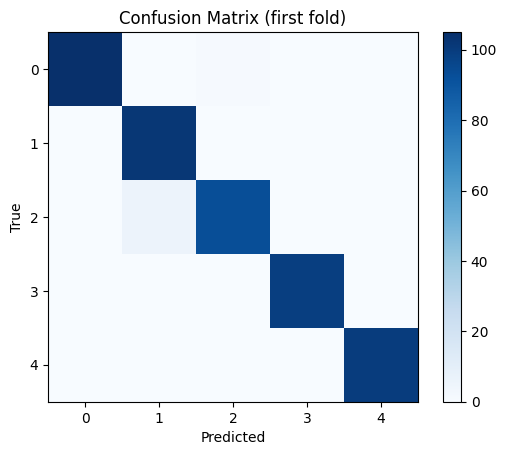

              precision    recall  f1-score   support

        KIRC       1.00      0.99      1.00       527
        LUAD       0.92      0.98      0.95       510
        LUSC       0.97      0.92      0.94       498
        PRAD       1.00      1.00      1.00       493
        THCA       1.00      1.00      1.00       501

    accuracy                           0.98      2529
   macro avg       0.98      0.98      0.98      2529
weighted avg       0.98      0.98      0.98      2529



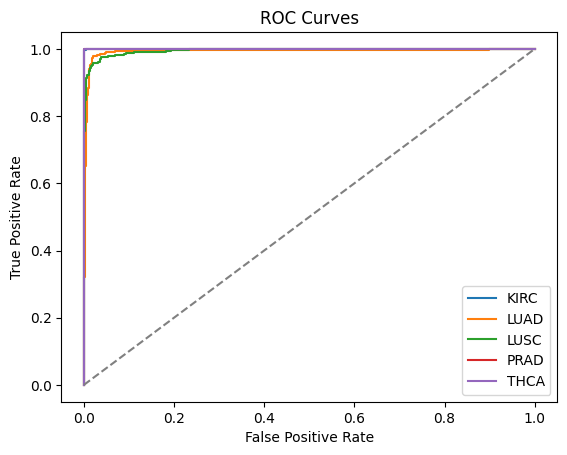

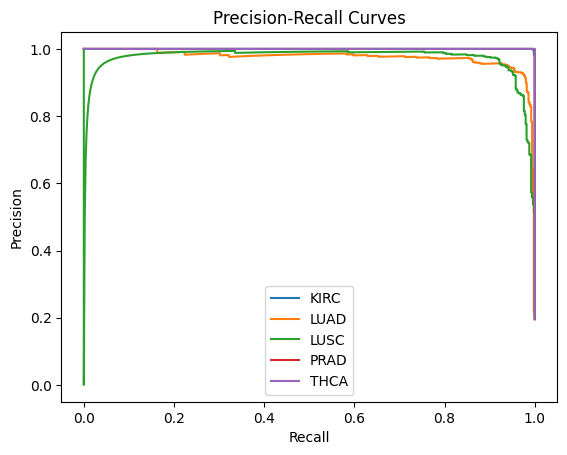

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# from tensorflow import keras
# from tensorflow.keras import layers

# from sklearn.model_selection import StratifiedKFold, cross_val_predict
# from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
# from sklearn.pipeline import Pipeline
# from sklearn.svm import SVC
# from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# --- 1) Build and train Autoencoder ---
input_dim = X.shape[1]
encoding_dim = 50

input_layer = keras.Input(shape=(input_dim,))
encoded = layers.Dense(200, activation="relu")(input_layer)
bottleneck = layers.Dense(encoding_dim, activation="linear")(encoded)
decoded = layers.Dense(200, activation="relu")(bottleneck)
decoded = layers.Dense(input_dim, activation="linear")(decoded)

autoencoder = keras.Model(input_layer, decoded)
encoder = keras.Model(input_layer, bottleneck)

autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(X, X, epochs=10, batch_size=64, shuffle=True, verbose=1)

# Extract 50-dim features
X_ae = encoder.predict(X)

# --- 2) Train SVM with 5-fold CV ---
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_

svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", probability=True, random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Confusion matrix for the first fold
train_idx, test_idx = next(cv.split(X_ae, y_enc))
svm.fit(X_ae[train_idx], y_enc[train_idx])
y_pred_fold = svm.predict(X_ae[test_idx])
cm = confusion_matrix(y_enc[test_idx], y_pred_fold)

plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (first fold)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- 3) Metrics with cross-validation predictions ---
y_pred_cv = cross_val_predict(svm, X_ae, y_enc, cv=cv, method="predict")
y_prob_cv = cross_val_predict(svm, X_ae, y_enc, cv=cv, method="predict_proba")

print(classification_report(y_enc, y_pred_cv, target_names=class_names))

# --- 4) ROC & PR curves (one-vs-rest style) ---
y_bin = label_binarize(y_enc, classes=np.arange(len(class_names)))

for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob_cv[:, i])
    precision, recall, _ = precision_recall_curve(y_bin[:, i], y_prob_cv[:, i])

    # Plot ROC
    plt.plot(fpr, tpr, label=f"{cls}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot PR curves
for i, cls in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], y_prob_cv[:, i])
    plt.plot(recall, precision, label=f"{cls}")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


Task 4: [25 points] Concrete Autoencoder for Feature Selection

Train a Concrete Autoencoder to select 50 actual features. Train an SVM with RBF kernel on
those 50 selected features. Report (i) confusion matrix for one fold, (ii) the macro, micro, and
weighted precision/recall/F1 along with the accuracy, (iii) plot AUC-ROC and AUC-PR curve.

Epoch 0: mean max prob=0.0001, temp=10.0000
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - loss: 0.2843
Epoch 1: mean max prob=0.0001, temp=9.1201
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1155
Epoch 2: mean max prob=0.0001, temp=8.3176
Epoch 3/50


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1038
Epoch 3: mean max prob=0.0001, temp=7.5858
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1027
Epoch 4: mean max prob=0.0001, temp=6.9183
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1020
Epoch 5: mean max prob=0.0001, temp=6.3095
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1037
Epoch 6: mean max prob=0.0001, temp=5.7544
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1023
Epoch 7: mean max prob=0.0001, temp=5.2480
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1030
Epoch 8: mean max prob=0.0001, temp=4.7863
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1047
Epoch 9: mean max prob=0.0001, temp=4.3651
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1040
Epoch 10: mean max prob=0.0001, temp=3.9810
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1009
Epoch 11: mean max prob=0.0001, temp=3.6307
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━

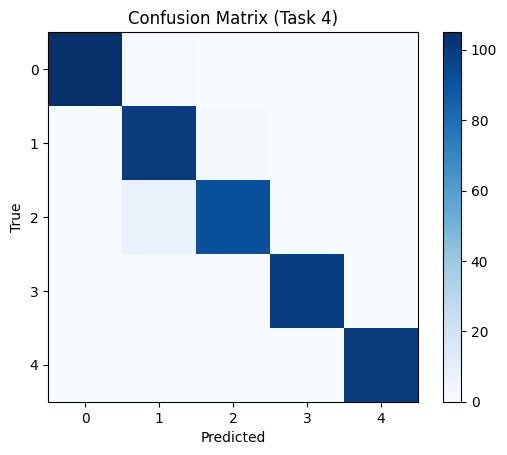


Classification Report:

              precision    recall  f1-score   support

        KIRC       1.00      0.99      1.00       527
        LUAD       0.89      0.97      0.93       510
        LUSC       0.97      0.89      0.92       498
        PRAD       1.00      1.00      1.00       493
        THCA       1.00      1.00      1.00       501

    accuracy                           0.97      2529
   macro avg       0.97      0.97      0.97      2529
weighted avg       0.97      0.97      0.97      2529



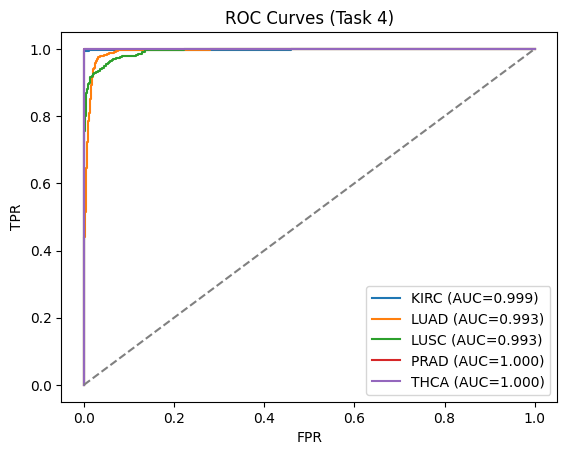

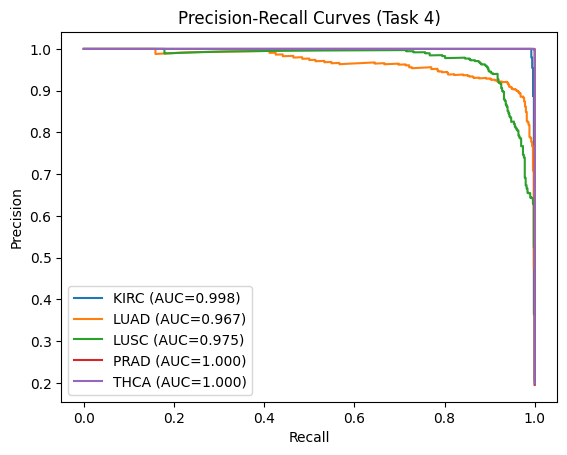

In [ ]:
# ---------------------------
# 1. Imports & setup
# ---------------------------
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant, glorot_normal
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve
)

!pip install tensorflow==2.12.0 concrete-autoencoder
!pip install concrete-autoencoder
from concrete_autoencoder import ConcreteAutoencoderFeatureSelector

# Patch missing Keras functions for TF >= 2.12
if not hasattr(K, "set_learning_phase"):
    K.set_learning_phase = lambda x: None
if not hasattr(K, "constant"):
    K.constant = tf.constant

# ---------------------------
# 2. ConcreteAutoencoderFeatureSelector class
# ---------------------------
class ConcreteSelect(Layer):
    def __init__(self, output_dim, start_temp=10.0, min_temp=0.1, alpha=0.99999, **kwargs):
        self.output_dim = output_dim
        self.start_temp = start_temp
        self.min_temp = K.constant(min_temp)
        self.alpha = K.constant(alpha)
        super(ConcreteSelect, self).__init__(**kwargs)

    def build(self, input_shape):
        self.temp = self.add_weight(
            name="temp",
            shape=[],
            initializer=Constant(self.start_temp),
            trainable=False,
        )
        self.logits = self.add_weight(
            name="logits",
            shape=(self.output_dim, input_shape[1]),
            initializer=glorot_normal(),
            trainable=True,
        )
        super(ConcreteSelect, self).build(input_shape)

    def call(self, X, training=None):
        uniform = K.random_uniform(self.logits.shape, K.epsilon(), 1.0)
        gumbel = -K.log(-K.log(uniform))

        # update temperature manually (instead of K.update)
        new_temp = K.maximum(self.min_temp, self.temp * self.alpha)
        self.temp.assign(new_temp)

        noisy_logits = (self.logits + gumbel) / self.temp
        samples = K.softmax(noisy_logits)

        discrete_logits = K.one_hot(K.argmax(self.logits), self.logits.shape[1])

        # use tf.cond instead of K.in_train_phase
        if training is None:
            training = K.learning_phase()

        selections = tf.cond(
            tf.cast(training, tf.bool),
            lambda: samples,
            lambda: tf.cast(discrete_logits, tf.float32),
        )

        self.selections = selections
        Y = K.dot(X, K.transpose(selections))
        return Y

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

class StopperCallback(EarlyStopping):
    def __init__(self, mean_max_target=0.998):
        self.mean_max_target = mean_max_target
        super(StopperCallback, self).__init__(monitor='', patience=float('inf'), mode='max')

    def on_epoch_begin(self, epoch, logs=None):
        monitor_value = K.get_value(
            K.mean(K.max(K.softmax(self.model.get_layer('concrete_select').logits), axis=-1))
        )
        print(f'Epoch {epoch}: mean max prob={monitor_value:.4f}, temp={K.get_value(self.model.get_layer("concrete_select").temp):.4f}')

class ConcreteAutoencoderFeatureSelector():
    def __init__(self, K, output_function, num_epochs=100, batch_size=None, learning_rate=0.001,
                 start_temp=10.0, min_temp=0.1, tryout_limit=5):
        self.K = K
        self.output_function = output_function
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.start_temp = start_temp
        self.min_temp = min_temp
        self.tryout_limit = tryout_limit

    def fit(self, X, Y=None, val_X=None, val_Y=None):
        if Y is None:
            Y = X
        if self.batch_size is None:
            self.batch_size = max(len(X) // 256, 16)
        num_epochs = self.num_epochs
        steps_per_epoch = (len(X) + self.batch_size - 1) // self.batch_size

        for i in range(self.tryout_limit):
            inputs = Input(shape=X.shape[1:])
            alpha = math.exp(math.log(self.min_temp / self.start_temp) / (num_epochs * steps_per_epoch))
            self.concrete_select = ConcreteSelect(self.K, self.start_temp, self.min_temp, alpha, name='concrete_select')
            selected_features = self.concrete_select(inputs)
            outputs = self.output_function(selected_features)
            self.model = Model(inputs, outputs)
            self.model.compile(Adam(self.learning_rate), loss='mse')

            stopper = StopperCallback()
            self.model.fit(X, Y, self.batch_size, num_epochs, verbose=1, callbacks=[stopper])
            if K.get_value(K.mean(K.max(K.softmax(self.concrete_select.logits, axis=-1)))) >= stopper.mean_max_target:
                break
            num_epochs *= 2

        self.probabilities = K.get_value(K.softmax(self.model.get_layer('concrete_select').logits))
        self.indices = K.get_value(K.argmax(self.model.get_layer('concrete_select').logits))
        return self

    def get_support(self, indices=False):
        return self.indices if indices else self.probabilities

# ---------------------------
# 3. Data prep
# ---------------------------
X_features = df.drop(columns=["Ensembl_ID", "Class"])
y = df["Class"]

def decoder(x):
    x = Dense(200, activation="relu")(x)
    x = Dense(X_features.shape[1], activation="linear")(x)
    return x

selector = ConcreteAutoencoderFeatureSelector(K=50, output_function=decoder, num_epochs=50, batch_size=64)
selector.fit(X_features.values, X_features.values)

selected_idx = selector.get_support(indices=True)
selected_features = X_features.columns[selected_idx]
print("Selected features (first 10):", selected_features[:10])

X_selected = X_features[selected_features]

# ---------------------------
# 4. SVM evaluation
# ---------------------------
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_

svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", probability=True, random_state=42))
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# (i) Confusion matrix (first fold)
train_idx, test_idx = next(cv.split(X_selected, y_enc))
svm.fit(X_selected.iloc[train_idx], y_enc[train_idx])
y_pred_fold = svm.predict(X_selected.iloc[test_idx])
cm = confusion_matrix(y_enc[test_idx], y_pred_fold)
print("\nConfusion Matrix (first fold):\n", cm)

plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Task 4)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# (ii) Classification report
y_pred_cv = cross_val_predict(svm, X_selected, y_enc, cv=cv, method="predict")
y_prob_cv = cross_val_predict(svm, X_selected, y_enc, cv=cv, method="predict_proba")
print("\nClassification Report:\n")
print(classification_report(y_enc, y_pred_cv, target_names=class_names))

# (iii) ROC & PR curves
y_bin = label_binarize(y_enc, classes=np.arange(len(class_names)))

# ROC
for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob_cv[:, i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],"--",color="gray")
plt.title("ROC Curves (Task 4)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

# PR
for i, cls in enumerate(class_names):
    prec, rec, _ = precision_recall_curve(y_bin[:, i], y_prob_cv[:, i])
    plt.plot(rec, prec, label=f"{cls} (AUC={auc(rec,prec):.3f})")
plt.title("Precision-Recall Curves (Task 4)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


# Homework 2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
# Loading the CSV in colab
df = pd.read_csv("lncRNA_5_Cancers.csv")

# Peek at the data
print(df.shape)
df.head()



(2529, 12311)


,Ensembl_ID,ENSG00000005206.15,ENSG00000083622.8,ENSG00000088970.14,ENSG00000099869.7,ENSG00000100181.20,ENSG00000104691.13,ENSG00000115934.11,ENSG00000117242.7,ENSG00000118412.11,...,ENSGR0000223511.4,ENSGR0000223571.4,ENSGR0000226179.4,ENSGR0000230542.4,ENSGR0000234622.4,ENSGR0000236017.6,ENSGR0000236871.5,ENSGR0000237531.4,ENSGR0000270726.4,Class
0,TCGA-3Z-A93Z-01A,3.390813,0.0,2.918265,0.014832,0.341984,2.194036,0.0,1.569750,1.159419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KIRC
1,TCGA-6D-AA2E-01A,3.144547,0.0,1.961410,0.047186,1.677598,2.605298,0.0,1.180583,1.127571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KIRC
2,TCGA-A3-3306-01A,2.484817,0.0,2.896470,0.000000,0.087972,3.176764,0.0,1.690582,1.161923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KIRC
3,TCGA-A3-3307-01A,2.789058,0.0,2.439171,0.022316,0.502293,2.679842,0.0,1.659525,1.463067,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KIRC
4,TCGA-A3-3308-01A,3.258763,0.0,1.941660,0.050283,0.098625,2.841588,0.0,1.296678,1.728514,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KIRC


# Task 1


*   Visualize the lncRNA expression data of five different cancer types using PCA.
*   Reduce the data dimension from 12,309 to two (PC1 and PC2) dimensions and plot the data into reduced dimensions.
*   Must plot all the data of five cancer types.







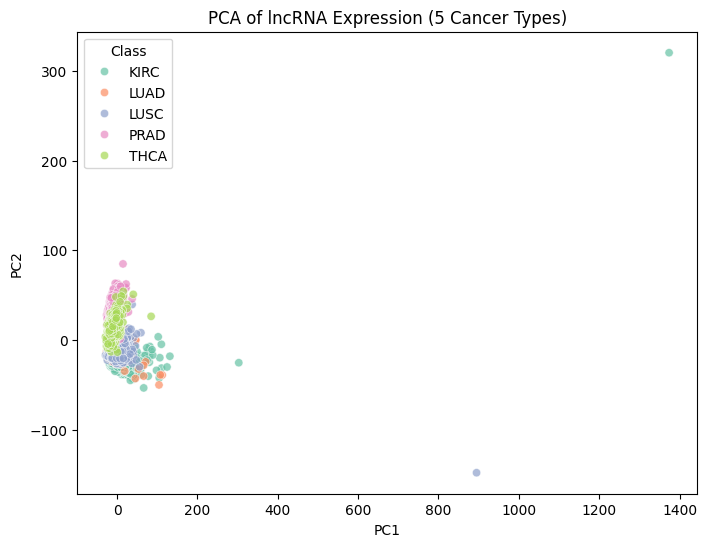

In [ ]:

# Drop non-numeric columns (like SampleID and Class)
X = df.drop(columns=["Class", "Ensembl_ID"])
y = df["Class"]

# Standardize features
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame
pca_df = pd.DataFrame(data=X_pca, columns=["PC1", "PC2"])
pca_df["Class"] = y.values

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="Class",
    palette="Set2",
    alpha=0.7
)
plt.title("PCA of lncRNA Expression (5 Cancer Types)")
plt.show()


# Task 2
Draw two violon plots – one with the values of PC1 and the other with
PC2.

/tmp/ipython-input-3186022873.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Class", y="PC1", data=pca_df, palette="Set2")


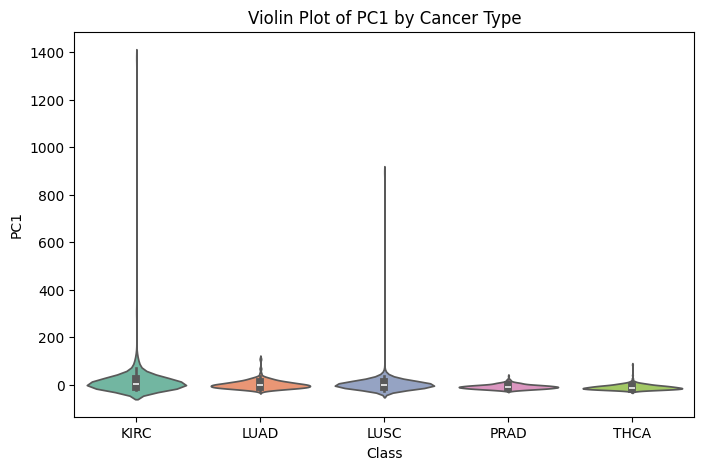

/tmp/ipython-input-3186022873.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Class", y="PC2", data=pca_df, palette="Set2")


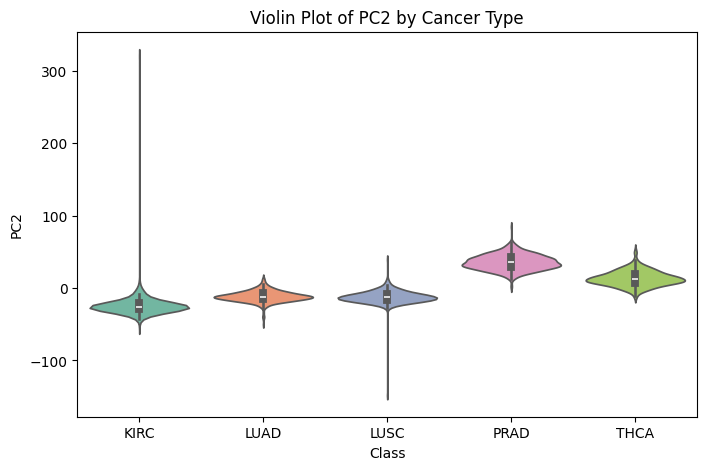

In [ ]:
# Violin plot for PC1
plt.figure(figsize=(8,5))
sns.violinplot(x="Class", y="PC1", data=pca_df, palette="Set2")
plt.title("Violin Plot of PC1 by Cancer Type")
plt.show()

# Violin plot for PC2
plt.figure(figsize=(8,5))
sns.violinplot(x="Class", y="PC2", data=pca_df, palette="Set2")
plt.title("Violin Plot of PC2 by Cancer Type")
plt.show()


# Task 3
* Repeat task 1 using t-SNE library.
* Plot the data in reduced dimension using two t-SNE components (t-SNE 1 and t-SNE 2).

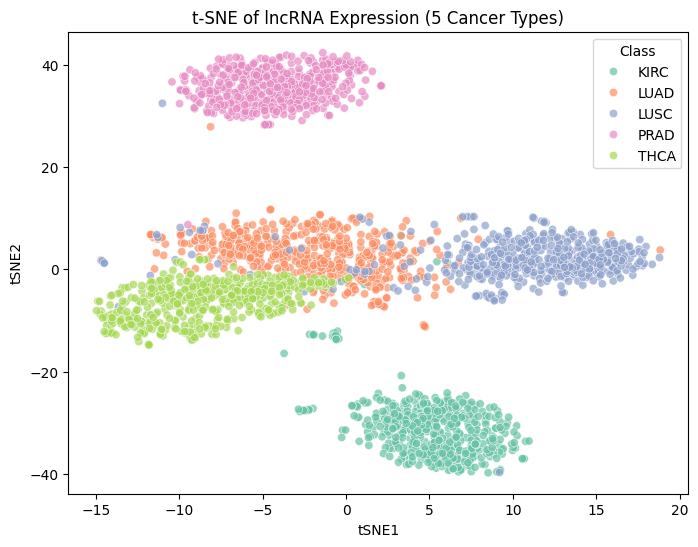

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE (reduce to 2 dimensions)
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Put into DataFrame for plotting
tsne_df = pd.DataFrame(data=X_tsne, columns=["tSNE1", "tSNE2"])
tsne_df["Class"] = y.values

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=tsne_df,
    x="tSNE1", y="tSNE2",
    hue="Class",
    palette="Set2",
    alpha=0.7
)
plt.title("t-SNE of lncRNA Expression (5 Cancer Types)")
plt.show()


# Task 4
 Draw two violon plots – one with the values of t-SNE 1 and the other with tSNE 2.

/tmp/ipython-input-2031718986.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Class", y="tSNE1", data=tsne_df, palette="Set2")


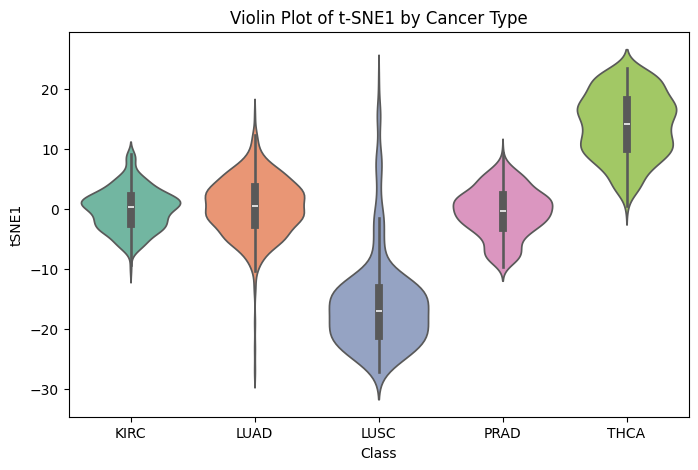

/tmp/ipython-input-2031718986.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Class", y="tSNE2", data=tsne_df, palette="Set2")


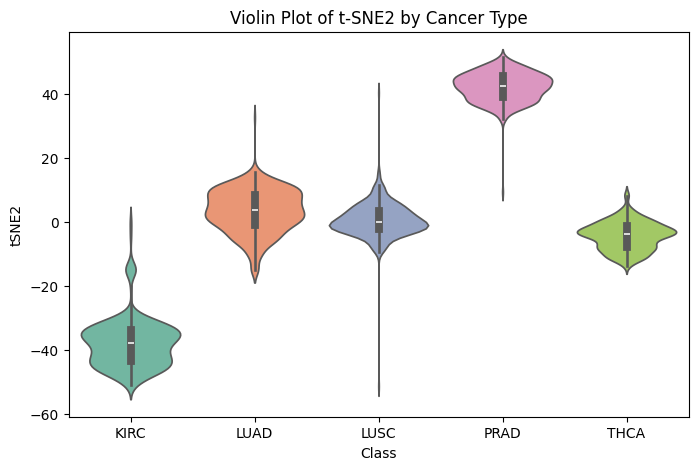

In [ ]:
# Violin plot for t-SNE1
plt.figure(figsize=(8,5))
# sns.violinplot(x="Class", y="tSNE1", data=tsne_df, palette="Set2")
sns.violinplot(x="Class", y="tSNE1", data=tsne_df, palette="Set2")
plt.title("Violin Plot of t-SNE1 by Cancer Type")
plt.show()

# Violin plot for t-SNE2
plt.figure(figsize=(8,5))
# sns.violinplot(x="Class", y="tSNE2", data=tsne_df, palette="Set2")
sns.violinplot(x="Class", y="tSNE2", data=tsne_df, palette="Set2")
plt.title("Violin Plot of t-SNE2 by Cancer Type")
plt.show()
